In [1]:
import pandas as pd
import numpy as np
seed = np.random.seed
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score
from IPython.display import display

In [2]:
df = pd.read_csv('https://archive.ics.uci.edu/ml/'
        'machine-learning-databases/iris/iris.data', header=None)
df.columns = ['Sepal length', 'Sepal width', 'Petal length', 'Petal width', 'Class label']
display(df.head())

X = df[['Petal length', 'Petal width']].values
y = pd.factorize(df['Class label'])[0]

# discard exmaples in the first class
X = X[50:150]
y = np.where(y[50:150] == 2, -1, y[50:150])

# train:test = 0.8:0.2
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1)

sc = StandardScaler()
sc.fit(X_train)
X_train_std = sc.transform(X_train)
X_test_std = sc.transform(X_test)

print('#Training data points: %d' % X_train.shape[0])
print('#Testing data points: %d' % X_test.shape[0])
print('Class labels: %s' % np.unique(y))

,Sepal length,Sepal width,Petal length,Petal width,Class label
0,5.1,3.5,1.4,0.2,Iris-setosa
1,4.9,3.0,1.4,0.2,Iris-setosa
2,4.7,3.2,1.3,0.2,Iris-setosa
3,4.6,3.1,1.5,0.2,Iris-setosa
4,5.0,3.6,1.4,0.2,Iris-setosa


#Training data points: 80
#Testing data points: 20
Class labels: [-1  1]


## Mini-batch Gradient Descent

In [192]:
class AdalineMBGD(object):
    """ADAptive LInear NEuron classifier.

    Parameters
    ------------
    eta : float
        Learning rate (between 0.0 and 1.0)
    n_iter : int
        Passes over the training dataset.

    Attributes
    -----------
    w_ : 1d-array
        Weights after fitting.
    errors_ : list
        Number of misclassifications in every epoch.
    shuffle : bool (default: True)
        Shuffles training data every epoch if True to prevent cycles.
    random_state : int
        Set random state for shuffling and initializing the weights.
        
    """
    def __init__(self, eta=0.01, n_iter=50, shuffle=True, random_state=1, batch_size=1):
        self.eta = eta
        self.n_iter = n_iter
        self.w_initialized = False
        self.shuffle = shuffle
        self.batch_size = batch_size
        if random_state : seed(random_state)
        
    def fit(self, X, y):
        """ Fit training data.

        Parameters
        ----------
        X : array-like; shape = [n_samples, n_features]
            Training vectors, where n_samples is the number of samples and
            n_features is the number of features.
        y : array-like; shape = [n_samples]
            Target values or labels.

        Returns
        -------
        self : object

        """
        numBatches = int(X.shape[0]/self.batch_size)
        print(X.shape[0], X.shape[1])
        
        self._initialize_weights(X.shape[1])
        self.cost_ = []
        self.theta = np.zeros((X.shape[1], 1))
        for i in range(self.n_iter):
            if self.shuffle:
                X, y = self._shuffle(X, y)
            cost = 0.0
            for i in range(0,len(y),self.batch_size):
                """ perform mini-batch gradient descent, calculate theta and cost by using X_i, y_i """
                X_i = X[i:i+self.batch_size]
                y_i = y[i:i+self.batch_size]
                prediction = np.dot(X_i, self.theta)
                loss = prediction - y_i
                gradient = np.dot(X_i.T, loss)/self.batch_size
                self.theta = self.theta - self.eta*gradient # update theta
                cost += self.cal_cost(self.theta, X_i, y_i)
                
                # Update rule
                error = y_i - self.activation(X_i)
                self.w_[1:] += self.eta * X_i.T.dot(error)
                self.w_[0] += self.eta * error.sum()
                
            avg_cost = cost / len(y)
            self.cost_.append(avg_cost)
            
        print("cost per iteration", self.cost_)
        return self

    def cal_cost(self,theta,X,y):
        m = len(y)
        predictions = X.dot(theta)
        cost = (1/2*m) * np.sum(np.square(predictions-y))
        return cost
        
    def get_batches(X, y, batch_size, i):
        """ dividing the data into batches """
        X_new = X[i:i+batch_size,:]
        y_new = y[i:i+batch_size]
        return X_new, y_new
    
    def _shuffle(self, X, y):
        """Shuffle training data"""
        r = np.random.permutation(len(y))
        return X[r], y[r]
    
    def _initialize_weights(self, m):
        """Randomly initialize weights"""
        self.w_ = np.random.normal(loc=0.0, scale=0.01, size=1 + m)
        self.w_initialized = True
        
    def _update_weights(self, xi, yi):
        """Apply Adaline learning rule to update the weights"""
        #output = self.activation(xi)
        
        # Cost function
        #error = (yi - output)
        #cost = 0.5 * error**2
        
        # Update rule
        #self.w_[1:] += self.eta * xi.dot(error)
        #self.w_[0] += self.eta * error
        
        return cost
    
    def net_input(self, X):
        """Calculate net input"""
        return np.dot(X, self.w_[1:]) + self.w_[0]

    def activation(self, X):
        """Compute linear activation"""
        return self.net_input(X)

    def predict(self, X):
        """Return class label after unit step"""
        return np.where(self.activation(X) >= 0.0, 1, -1)

    def partial_fit(self, X, y):
        """Fit training data without reinitializing the weights"""
        if not self.w_initialized:
            self._initialize_weights(X.shape[1])
        if y.ravel().shape[0] > 1:
            for xi, yi in zip(X, y):
                self._update_weights(xi, yi)
        else:
            self._update_weights(X, y)
        return self

In [193]:
## batch_size = 1
adas = AdalineMBGD(n_iter=20, eta=0.01, random_state=1, batch_size=1)
adas.fit(X_train_std, y_train)

## batch_size = 2
adas2 = AdalineMBGD(n_iter=20, eta=0.001, random_state=1, batch_size=2)
adas2.fit(X_train_std, y_train)

## batch_size = 4
adas3 = AdalineMBGD(n_iter=20, eta=0.001, random_state=1, batch_size=4)
adas3.fit(X_train_std, y_train)

80 2
cost per iteration [0.25281040584546266, 0.14005438007177856, 0.13381166003981865, 0.13232782188502706, 0.13268986943284983, 0.1319747643078916, 0.13181757073107633, 0.13184019907174163, 0.13165976395549367, 0.13147452391090178, 0.1315386458788844, 0.13117925698914795, 0.1307863785309135, 0.1312923913650948, 0.1312683753634414, 0.13132323903825566, 0.1308028739642012, 0.1311871956121643, 0.1310837928052915, 0.13139235470569213]
80 2
cost per iteration [1.9687815183511925, 1.9109052525542816, 1.8258866086172518, 1.7631142583025923, 1.7689507049809456, 1.6954809348099835, 1.745377044377534, 1.7384428298881296, 1.8255342133877064, 1.7112645080730284, 1.6995109429720485, 1.7980642902837238, 1.7456078072089856, 1.6346175874148963, 1.6934062200080056, 1.6624446345872823, 1.8632573875545002, 1.6298291779743086, 1.6091557124814753, 1.6414199734031674]
80 2
cost per iteration [7.967950081758145, 7.969353609579161, 7.899364955656543, 7.9086825527276545, 7.909029570146224, 7.810048719361028,

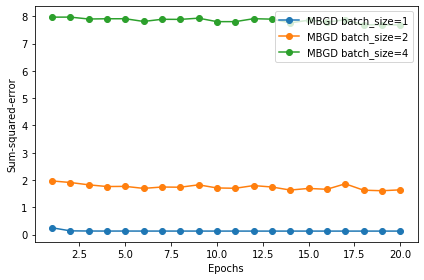

In [194]:
# Cost values
plt.plot(range(1, len(adas.cost_) + 1), adas.cost_, 
         marker='o', label='MBGD batch_size=1')
plt.plot(range(1, len(adas2.cost_) + 1), adas2.cost_, 
         marker='o', label='MBGD batch_size=2')
plt.plot(range(1, len(adas3.cost_) + 1), adas3.cost_, 
         marker='o', label='MBGD batch_size=4')

plt.xlabel('Epochs')
plt.ylabel('Sum-squared-error')
plt.legend(loc='upper right')

plt.tight_layout()
plt.show()

Misclassified samples: 3
Accuracy: 0.85


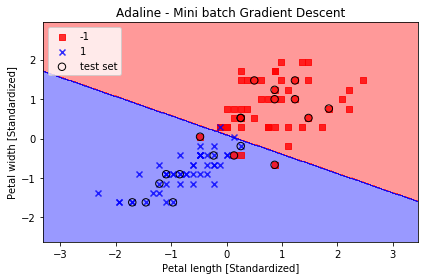

In [184]:
# batch size = 1

# Testing accuracy
y_pred = adas.predict(X_test_std)
print('Misclassified samples: %d' % (y_test != y_pred).sum())
print('Accuracy: %.2f' % accuracy_score(y_test, y_pred))

# Plot decision boundary 
X_combined_std = np.vstack((X_train_std, X_test_std))
y_combined = np.hstack((y_train, y_test))
plot_decision_regions(X_combined_std, y_combined, 
                      classifier=adas, test_idx=range(len(y_train),
                                                      len(y_train) + len(y_test)))

plt.title('Adaline - Mini batch Gradient Descent')
plt.xlabel('Petal length [Standardized]')
plt.ylabel('Petal width [Standardized]')
plt.legend(loc='upper left')
plt.tight_layout()
plt.show()

Misclassified samples: 3
Accuracy: 0.85


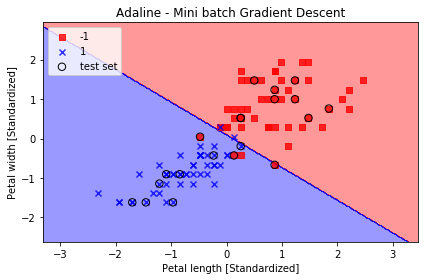

In [185]:
# batch size = 2

# Testing accuracy
y_pred = adas2.predict(X_test_std)
print('Misclassified samples: %d' % (y_test != y_pred).sum())
print('Accuracy: %.2f' % accuracy_score(y_test, y_pred))

# Plot decision boundary 
X_combined_std = np.vstack((X_train_std, X_test_std))
y_combined = np.hstack((y_train, y_test))
plot_decision_regions(X_combined_std, y_combined, 
                      classifier=adas2, test_idx=range(len(y_train),
                                                      len(y_train) + len(y_test)))

plt.title('Adaline - Mini batch Gradient Descent')
plt.xlabel('Petal length [Standardized]')
plt.ylabel('Petal width [Standardized]')
plt.legend(loc='upper left')
plt.tight_layout()
plt.show()

Misclassified samples: 3
Accuracy: 0.85


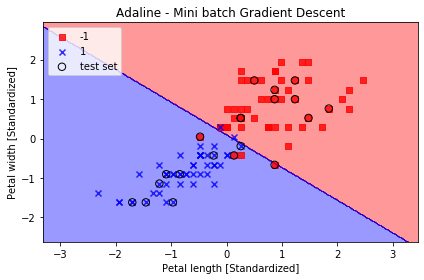

In [186]:
# batch size = 4

# Testing accuracy
y_pred = adas3.predict(X_test_std)
print('Misclassified samples: %d' % (y_test != y_pred).sum())
print('Accuracy: %.2f' % accuracy_score(y_test, y_pred))

# Plot decision boundary 
X_combined_std = np.vstack((X_train_std, X_test_std))
y_combined = np.hstack((y_train, y_test))
plot_decision_regions(X_combined_std, y_combined, 
                      classifier=adas3, test_idx=range(len(y_train),
                                                      len(y_train) + len(y_test)))

plt.title('Adaline - Mini batch Gradient Descent')
plt.xlabel('Petal length [Standardized]')
plt.ylabel('Petal width [Standardized]')
plt.legend(loc='upper left')
plt.tight_layout()
plt.show()

In [6]:
def plot_decision_regions(X, y, classifier, test_idx=None, resolution=0.02):

    # setup marker generator and color map
    markers = ('s', 'x', 'o', '^', 'v')
    colors = ('red', 'blue', 'lightgreen', 'gray', 'cyan')
    cmap = ListedColormap(colors[: len(np.unique(y))])

    # plot the decision surface
    x1_min, x1_max = X[:, 0].min() - 1, X[:, 0].max() + 1
    x2_min, x2_max = X[:, 1].min() - 1, X[:, 1].max() + 1
    xx1, xx2 = np.meshgrid(np.arange(x1_min, x1_max, resolution),
                           np.arange(x2_min, x2_max, resolution))

    Z = classifier.predict(np.array([xx1.ravel(), xx2.ravel()]).T)
    Z = Z.reshape(xx1.shape)
    plt.contourf(xx1, xx2, Z, alpha=0.4, cmap=cmap)
    plt.xlim(xx1.min(), xx1.max())
    plt.ylim(xx2.min(), xx2.max())

    # plot class samples
    for idx, cl in enumerate(np.unique(y)):
        plt.scatter(
            x = X[y == cl, 0],
            y = X[y == cl, 1],
            alpha = 0.8,
            c = [cmap(idx)], # Prevents warning
            marker = markers[idx],
            label = cl
        )

    # highlight test samples
    if test_idx:
        # plot all samples
        X_test, y_test = X[test_idx, :], y[test_idx]

        plt.scatter(X_test[:, 0],
                    X_test[:, 1],
                    c='',
                    alpha=1.0,
                    linewidths=1,
                    marker='o',
                    s=55, label='test set', edgecolors='k')

## SGD (original)

In [23]:
class AdalineSGD(object):
    """ADAptive LInear NEuron classifier.

    Parameters
    ------------
    eta : float
        Learning rate (between 0.0 and 1.0)
    n_iter : int
        Passes over the training dataset.

    Attributes
    -----------
    w_ : 1d-array
        Weights after fitting.
    errors_ : list
        Number of misclassifications in every epoch.
    shuffle : bool (default: True)
        Shuffles training data every epoch if True to prevent cycles.
    random_state : int
        Set random state for shuffling and initializing the weights.
        
    """
    def __init__(self, eta=0.01, n_iter=50, shuffle=True, random_state=1):
        self.eta = eta
        self.n_iter = n_iter
        self.w_initialized = False
        self.shuffle = shuffle
        if random_state : seed(random_state)
        
    def fit(self, X, y):
        """ Fit training data.

        Parameters
        ----------
        X : array-like; shape = [n_samples, n_features]
            Training vectors, where n_samples is the number of samples and
            n_features is the number of features.
        y : array-like; shape = [n_samples]
            Target values or labels.

        Returns
        -------
        self : object

        """
        self._initialize_weights(X.shape[1])
        self.cost_ = []
        for i in range(self.n_iter):
            if self.shuffle:
                X, y = self._shuffle(X, y)
            cost = []
            for xi, yi in zip(X, y):
                cost.append(self._update_weights(xi, yi))
            avg_cost = sum(cost) / len(y)
            self.cost_.append(avg_cost)
        return self

    def _shuffle(self, X, y):
        """Shuffle training data"""
        r = np.random.permutation(len(y))
        return X[r], y[r]
    
    def _initialize_weights(self, m):
        """Randomly initialize weights"""
        self.w_ = np.random.normal(loc=0.0, scale=0.01, size=1 + m)
        self.w_initialized = True
        
    def _update_weights(self, xi, yi):
        """Apply Adaline learning rule to update the weights"""
        output = self.activation(xi)
        
        # Cost function
        error = (yi - output)
        cost = 0.5 * error**2
        
        # Update rule
        self.w_[1:] += self.eta * xi.dot(error)
        self.w_[0] += self.eta * error
        
        return cost
    
    def net_input(self, X):
        """Calculate net input"""
        return np.dot(X, self.w_[1:]) + self.w_[0]

    def activation(self, X):
        """Compute linear activation"""
        return self.net_input(X)

    def predict(self, X):
        """Return class label after unit step"""
        return np.where(self.activation(X) >= 0.0, 1, -1)

    def partial_fit(self, X, y):
        """Fit training data without reinitializing the weights"""
        if not self.w_initialized:
            self._initialize_weights(X.shape[1])
        if y.ravel().shape[0] > 1:
            for xi, yi in zip(X, y):
                self._update_weights(xi, yi)
        else:
            self._update_weights(X, y)
        return self

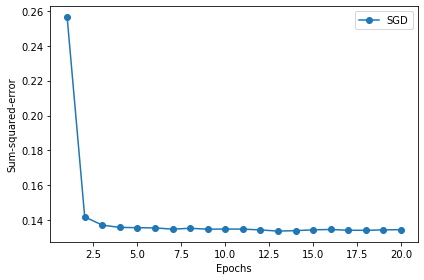

Misclassified samples: 3
Accuracy: 0.85


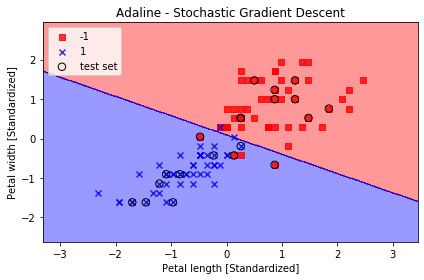

In [24]:
adas = AdalineSGD(n_iter=20, eta=0.01, random_state=1)
adas.fit(X_train_std, y_train)

# Cost values
plt.plot(range(1, len(adas.cost_) + 1), adas.cost_, 
         marker='o', label='SGD')
plt.xlabel('Epochs')
plt.ylabel('Sum-squared-error')
plt.legend(loc='upper right')

plt.tight_layout()
plt.show()

# Testing accuracy
y_pred = adas.predict(X_test_std)
print('Misclassified samples: %d' % (y_test != y_pred).sum())
print('Accuracy: %.2f' % accuracy_score(y_test, y_pred))

# Plot decision boundary 
plot_decision_regions(X_combined_std, y_combined, 
                      classifier=adas, test_idx=range(len(y_train),
                                                      len(y_train) + len(y_test)))
plt.title('Adaline - Stochastic Gradient Descent')
plt.xlabel('Petal length [Standardized]')
plt.ylabel('Petal width [Standardized]')
plt.legend(loc='upper left')
plt.tight_layout()
plt.show()